# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: May 2022

# First: load imports needed for the project and project preparation

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import os
import torch
import sklearn
import scipy

from datetime import datetime
from tqdm import tqdm
from scipy import stats
from platform import python_version

import utils_bsc

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')

saved_results = 'training_results'

# Check whether the directory where the results files must be saved exists or not
if not os.path.exists(saved_results):
  # Create a new directory because it does not exist
  os.makedirs(saved_results)

Device: CPU


In [3]:
print('versions of packages:')
print(f'Python: {python_version()}')
print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'PyTorch: {torch.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'scipy: {scipy.__version__}')

versions of packages:
Python: 3.9.2
Pandas: 1.3.3
Numpy: 1.20.3
PyTorch: 1.10.0
Sklearn: 1.0
seaborn: 0.11.2
scipy: 1.7.1


In [4]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

colab = False

if colab is True:
    cwd = os.getcwd()

    if cwd != "/content/Bsc_Thesis":
        ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
        % cd Bsc_Thesis

    print(cwd)

# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [5]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [6]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [7]:
print_data = False
print_graphs = False

In [8]:
if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [9]:
if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [10]:
# We print some graphs showing the density distribution of every feature
if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [11]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [12]:
if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [13]:
if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [14]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = utils_bsc.normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 983.95it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = utils_bsc.normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1922.14it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = utils_bsc.normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1791.79it/s]


In [17]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [18]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [19]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

# Correlation between features

We calculate the pearson correlation of all features and plot them into a heat map

In [20]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.953063892768616
Correlation between PLN1 and PLN3
0.9606664987977854
Correlation between PLN1 and ULL1
-0.7274016376341782
Correlation between PLN1 and ULL2
-0.6955282277514699
Correlation between PLN1 and ULL3
-0.7030835410050382
Correlation between PLN1 and COS_PHI1
0.8410401295195357
Correlation between PLN1 and COS_PHI2
0.6731338062873107
Correlation between PLN1 and COS_PHI3
0.812237030919215
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090616
Correlation between PLN1 and RC_AC
0.6311099014117807
Correlation between PLN1 and RC_50Hz
0.3688113546135111
Correlation between PLN1 and RC_150Hz
0.5078743784519381
Correlation between PLN1 and RC_<100Hz
0.43093253308676593
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453893
Correlation between PLN1 and RC_>1kHz
0.5928797475823844
Correlation between PLN1 and RC_>10kHz
0.31619183414655383
Mean of PLN1 cor

<AxesSubplot:>

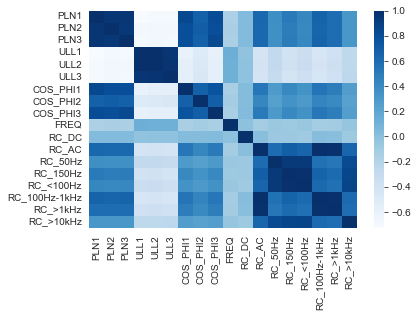

In [21]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

In [22]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

acc_variance = []

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  acc_variance.append(acc)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810273 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653476 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472382985 (accumulated 0.7702)
Explained_variance 4 principal component: 0.0549216270680284 (accumulated 0.8252)
Explained_variance 5 principal component: 0.053906168670765774 (accumulated 0.8791)
Explained_variance 6 principal component: 0.04952232661739351 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995553 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136352 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300312 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199087 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955786 (accumulated 0.9917)
Explained_variance 12 principal component: 0.0028939596101033465 (accumulated 0.99

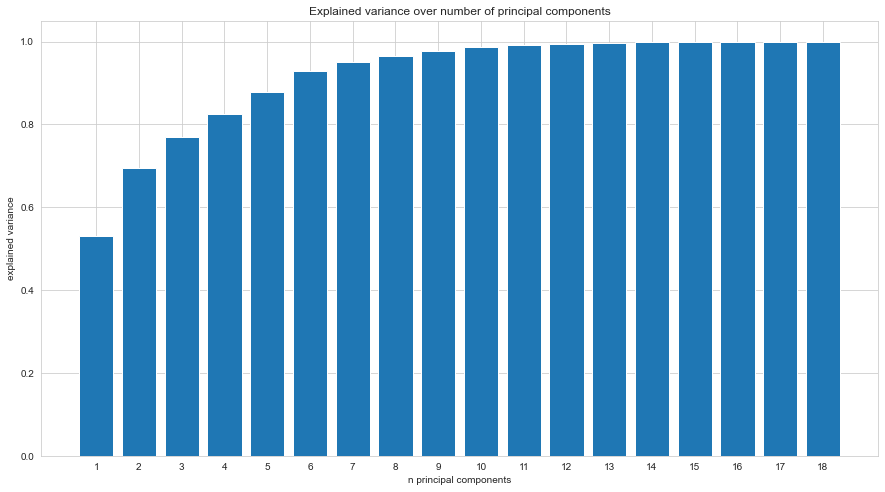

In [23]:
fig = plt.figure(figsize=(15,8))

a = acc_variance

b = [i +1 for i in range(len(acc_variance))]
plt.title('Explained variance over number of principal components')
plt.xlabel('n principal components')
plt.xticks(b)
plt.ylabel('explained variance')
plt.bar(b, a)
plt.show()

# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [ ]:
loader_train, loader_test = utils_bsc.create_dataloaders(dataset=dataset_norm, device=device)

Baseline model based in: Output element is the Input element

In [ ]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

# save to npy file to keep track of the results and to print graphs
np.save(saved_results + '/baseline_train.npy', losses_train)
np.save(saved_results + '/baseline_test.npy', losses_test)

if colab is True:
    files.download(saved_results + '/baseline_train.npy')
    files.download(saved_results + '/baseline_test.npy')

In [ ]:
print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))

Create a second baseline model based on a FFN. It predicts output element based on input element

In [ ]:
start_train_FFN = False

# Create model FFN instance
model_FFN = utils_bsc.ANN_relu(18, 18).to(device)

print(f'Model: {type(model_FFN).__name__}')
print(f'{utils_bsc.count_parameters(model_FFN)} trainable parameters.')

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
learning_rate=0.01
optimizer_whole = torch.optim.SGD(model_FFN.parameters(), lr=learning_rate)

if start_train_FFN is True:
    n_epochs = 10

    params_not_trained_whole = model_FFN.parameters()

    start_time = datetime.now()

    best_results , train_losses_FFN, test_losses_FFN = utils_bsc.train_FFN(model_FFN, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

    model_FFN = best_results[0]
    best_train_loss = best_results[1]
    best_test_loss = best_results[2]
    best_epoch_number = best_results[3]

    end_time = datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds()

    print(f'Best test loss at epoch {best_epoch_number}')
    print(f'Train Loss: {best_train_loss}')
    print(f'Test Loss: {best_test_loss}')
    print(f'\nTraining time for {n_epochs} epochs: {execution_time} seconds')


    # save to npy file
    np.save(saved_results + '/FFN_train.npy', train_losses_FFN)
    np.save(saved_results + '/FFN_test.npy', test_losses_FFN)
    torch.save(model_FFN, saved_results + '/model_FFN.pt')

    if colab is True:

        from google.colab import files

        files.download(saved_results + '/FFN_train.npy')
        files.download(saved_results + '/FFN_test.npy')
        files.download(saved_results + '/model_FFN.pt')

In [ ]:
if start_train_FFN is True:
    baseline_loss = [np.mean(losses_train) for i in range(len(train_losses_FFN))]
    utils_bsc.print_results_training(train_loss=train_losses_FFN, test_loss=test_losses_FFN, test_loss_baseline=baseline_loss, baseline_label='Baseline', title="Full Forward Neural Network train results")

# Transformer Model settings

Now, we train the actual transformer over the data set and print and store the results in a dictionary and in a file

In [ ]:
training_results_transformers ={}

Train Transformer 'Vanilla' model, with standard hyperparameters

models = {name: [number_of_encoder_layers, number_of_decoder_layers, number_of_heads, optimizer, learning_rate, momentum, train_model, sequence_length, batch_size]}

In [ ]:
models = {'vanilla': [6, 1, 6, 2048, 'SGD', 0.01, None, True, 30, 16]}

In [ ]:
training_results_transformers = utils_bsc.define_train_transformers(models, device, dataset_norm, training_results_transformers, saved_results, colab)

In [ ]:
if models['vanilla'][7] is True:

    baseline_loss = [np.mean(i) for i in test_losses_FFN]
    utils_bsc.print_results_training(train_loss=training_results_transformers['vanilla'][4], test_loss=training_results_transformers['vanilla'][5], test_loss_baseline=baseline_loss, baseline_label='FFN Test Loss', title="Training results " + 'vanilla' + " Transformer (" + str(models['vanilla'][0]) + " encoder layers, " + str(models['vanilla'][1]) + " decoder layer, " + str(models['vanilla'][2]) + " heads. " + models['vanilla'][4])

In [ ]:
models['vanilla'][7] = False

Train same transformer model but this time with ADAM optimizer

In [ ]:
models['ADAM'] = [6, 1, 6, 2048, 'ADAM', 0.001, None, True, 30, 16]

In [ ]:
training_results_transformers = utils_bsc.define_train_transformers(models, device, dataset_norm, training_results_transformers, saved_results, colab)

In [ ]:
if models['ADAM'][7] is True:

    baseline_loss = [np.mean(i) for i in training_results_transformers['vanilla'][5]]
    utils_bsc.print_results_training(train_loss=training_results_transformers['ADAM'][4], test_loss=training_results_transformers['ADAM'][5], test_loss_baseline=baseline_loss, baseline_label='Vanilla transformer Test Loss', title="Training results " + 'ADAM' + " Transformer (" + str(models['ADAM'][0]) + " encoder layers, " + str(models['ADAM'][1]) + " decoder layer, " + str(models['ADAM'][2]) + " heads. " + models['ADAM'][4])

In [ ]:
models['ADAM'][7] = False

Train same transformer but with SGD with momentum as optimiser

In [ ]:
models['Momentum'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 30, 16]

In [ ]:
training_results_transformers = utils_bsc.define_train_transformers(models, device, dataset_norm, training_results_transformers, saved_results, colab)

In [ ]:
if models['Momentum'][7] is True:

    baseline_loss = [np.mean(i) for i in training_results_transformers['vanilla'][5]]
    utils_bsc.print_results_training(train_loss=training_results_transformers['Momentum'][4], test_loss=training_results_transformers['Momentum'][5], test_loss_baseline=baseline_loss, baseline_label='Vanilla transformer Test Loss', title="Training results " + 'Momentum' + " Transformer (" + str(models['Momentum'][0]) + " encoder layers, " + str(models['Momentum'][1]) + " decoder layer, " + str(models['Momentum'][2]) + " heads. " + models['Momentum'][4])

In [ ]:
models['Momentum'][7] = False

Train the smallest transformer model with SGD with momentum as optimiser

In [ ]:
models['smallest'] = [1, 1, 1, 512, 'SGD', 0.001, 0.9, True, 30, 16]

In [ ]:
training_results_transformers = utils_bsc.define_train_transformers(models, device, dataset_norm, training_results_transformers, saved_results, colab)

In [ ]:
if models['smallest'][7] is True:

    baseline_loss = [np.mean(i) for i in training_results_transformers['vanilla'][5]]
    utils_bsc.print_results_training(train_loss=training_results_transformers['smallest'][4], test_loss=training_results_transformers['smallest'][5], test_loss_baseline=baseline_loss, baseline_label='Vanilla transformer Test Loss', title="Training results " + 'smallest' + " Transformer (" + str(models['smallest'][0]) + " encoder layers, " + str(models['smallest'][1]) + " decoder layer, " + str(models['smallest'][2]) + " heads. " + models['smallest'][4])

In [ ]:
models['smallest'][7] = False

Train a bigger transformer model with SGD with momentum as optimiser

In [ ]:
models['bigger'] = [10, 5, 9, 4096, 'SGD', 0.001, 0.9, True, 30, 16]

In [ ]:
training_results_transformers = utils_bsc.define_train_transformers(models, device, dataset_norm, training_results_transformers, saved_results, colab)

In [ ]:
if models['bigger'][7] is True:
    baseline_loss = [np.mean(i) for i in training_results_transformers['vanilla'][5]]
    utils_bsc.print_results_training(train_loss=training_results_transformers['bigger'][4], test_loss=training_results_transformers['bigger'][5], test_loss_baseline=baseline_loss, baseline_label='Vanilla transformer Test Loss', title="Training results " + 'bigger' + " Transformer (" + str(models['bigger'][0]) + " encoder layers, " + str(models['bigger'][1]) + " decoder layer, " + str(models['bigger'][2]) + " heads. " + models['bigger'][4])

In [ ]:
models['bigger'][7] = False

Try with different sequence lengths

In [ ]:
models['seq_15'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 15, 16]
models['seq_60'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 60, 16]
models['seq_2'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 2, 16]
models['seq_20'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 20, 16]
models['seq_10'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 10, 16]
models['seq_120'] = [6, 1, 6, 2048, 'SGD', 0.001, 0.9, True, 120, 16]

In [ ]:
print(models)

In [ ]:
training_results_transformers = utils_bsc.define_train_transformers(models, device, dataset_norm, training_results_transformers, saved_results, colab)

# Train LSTM

In [24]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, bias_init: float):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(self.lstm.hidden_size, output_size)

        # Deactivate forget gate to be in line with the original definition.
        def _reset_forget_gate_hook(_gradients: torch.Tensor) -> torch.Tensor:
            _gradients[_gradients.shape[0] // 4:_gradients.shape[0] // 2].fill_(0.0)
            return _gradients

        for name, parameter in self.lstm.named_parameters():
            if 'bias' in name:
                parameter.data[(parameter.shape[0] // 4):(parameter.shape[0] // 2)].fill_(bias_init)
                parameter.register_hook(_reset_forget_gate_hook)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lstm(x)[0][:, -1, :]
        return self.fc(x)

In [25]:
def training_lstm(model, optimizer, criterion, train_loader, test_loader, n_epochs, train_loss=None,
                         test_loss=None):
    if train_loss is not None:
        epoch_loss_train = train_loss
        best_train_loss = min([np.mean(i) for i in train_loss])
        best_epoch = np.where(min([np.mean(i) for i in test_loss]))
    else:
        epoch_loss_train = []
        best_train_loss = 9999999999
        best_epoch = 0

    if test_loss is not None:
        epoch_loss_test = test_loss
        best_test_loss = min([np.mean(i) for i in test_loss])
        best_epoch = np.where(min([np.mean(i) for i in train_loss]))
    else:
        epoch_loss_test = []
        best_test_loss = 99999999999
        best_epoch = 0

    best_model = model
    starting_epoch = len(epoch_loss_test)

    for e in range(1, n_epochs + 1):

        print(f'Epoch: {e + starting_epoch} of {n_epochs}')
        print('Training...')
        model.train()

        for i in tqdm(train_loader):
            input = i[0]
            target = i[1]

            net_out = model.forward(input)

            # Compute loss
            loss = criterion(net_out, target)

            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

            # Optimization
            optimizer.step()

        print('\nTest with training set')
        losses_train = []
        model.eval()
        with torch.no_grad():
            for i in tqdm(train_loader):
                input = i[0]
                target = i[2]

                net_out = model.forward(input)

                # Compute loss
                losses_train.append(float(criterion(net_out, target).item()))

        print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
        epoch_loss_train.append(losses_train)

        print('\nTest with test set')
        losses_test = []
        model.eval()

        with torch.no_grad():
            for i in tqdm(test_loader):
                input = i[0]
                target = i[1]

                net_out = model.forward(input)

                # Compute loss
                losses_test.append(float(criterion(net_out, target).item()))

        print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
        epoch_loss_test.append(losses_test)

        print('\n')

        if np.mean(losses_test) < best_test_loss:
            best_test_loss = np.mean(losses_test)
            best_train_loss = np.mean(losses_train)
            best_model = model
            best_epoch = e

    return (best_model, best_train_loss, best_test_loss, best_epoch), epoch_loss_train, epoch_loss_test

In [26]:
def define_train_lstm(models, device, dataset, training_results_transformers, path_save, colab):
    for i in models:
        if models[i][7] is True:

            loader_train, loader_test = utils_bsc.create_sequece_dataloaders(dataset=dataset, seq_length=models[i][8],
                                                                   batch_size=models[i][9], device=device)

            target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = LSTM(input_size=18, hidden_size= 32, output_size=18, bias_init=0.0).to(target_device)

            print(f'Model: {type(model).__name__} - {i}')
            print(f'{utils_bsc.count_parameters(model)} trainable parameters.')

            n_epochs = 200
            learning_rate = 0.01

            if models[i][4] == 'SGD':

                if models[i][6] is not None:
                    optimizer = torch.optim.SGD(model.parameters(), lr=models[i][5], momentum=models[i][6])
                else:
                    optimizer = torch.optim.SGD(model.parameters(), lr=models[i][5])
            elif models[i][4] == 'ADAM':
                optimizer = torch.optim.Adam(model.parameters(), lr=models[i][5])

            criterion = nn.MSELoss()

            start_time = datetime.now()

            best_results, train_losses, test_losses = training_lstm(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                train_loader=loader_train,
                test_loader=loader_test,
                n_epochs=n_epochs)

            Transformer_trained_Model = best_results[0]
            best_train_loss = best_results[1]
            best_test_loss = best_results[2]
            best_epoch_number = best_results[3]

            end_time = datetime.now()
            time_diff = (end_time - start_time)
            execution_time = time_diff.total_seconds()

            print(f'Best test loss at epoch {best_epoch_number}')
            print(f'Train Loss: {best_train_loss}')
            print(f'Test Loss: {best_test_loss}')
            print(f'\nTraining time for {n_epochs} epochs: {execution_time} seconds')

            print(f'Training time: {execution_time} seconds')

            training_results_transformers[i] = [Transformer_trained_Model, best_train_loss, best_test_loss,
                                                best_epoch_number, train_losses, test_losses, execution_time]

            # save to npy file
            np.save(path_save + '/Transformer_' + i + '_train.npy', train_losses)
            np.save(path_save + '/Transformer_' + i + '_test.npy', test_losses)
            torch.save(Transformer_trained_Model, path_save + '/Transformer_' + models[i][8] + '.pt')

            if colab is True:
                from google.colab import files

                files.download(path_save + '/Transformer_' + i + '_train.npy')
                files.download(path_save + '/Transformer_' + i + '_test.npy')
                files.download(path_save + '/Transformer_' + i + '.pt')

    return training_results_transformers

In [31]:
models = {}
training_results_lstm = {}

models['lstm'] = [1, 1, 1, 512, 'SGD', 0.001, 0.9, True, 30, 16]

training_results_lstm = define_train_lstm(models, device, dataset_norm, training_results_lstm, saved_results, colab)

Creating train/test data loaders


100%|██████████| 63329/63329 [00:19<00:00, 3173.71it/s]


Sequence length: 30
Batch size: 16
length of training set: 56996
length of test set: 6333


Model: LSTM - lstm
7250 trainable parameters.
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [00:19<00:00, 184.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:05<00:00, 654.38it/s]



Current Mean loss Train Set:  0.41421601637558025

Test with test set


100%|██████████| 396/396 [00:00<00:00, 600.33it/s]



Current Mean loss Test Set:  0.40699310469055416


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [00:19<00:00, 180.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:05<00:00, 647.66it/s]



Current Mean loss Train Set:  0.37420958667416404

Test with test set


100%|██████████| 396/396 [00:00<00:00, 603.89it/s]



Current Mean loss Test Set:  0.35885737644452037


Epoch: 3 of 200
Training...


 11%|█         | 385/3563 [00:02<00:17, 181.30it/s]


KeyboardInterrupt: 